In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

/Users/amihailovs/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Set Creation

### Transactions transformation

In [2]:
#Loading data from Data World: https://data.world/lpetrocelli/retail-banking-demo-data/workspace/intro
loan = pd.read_csv('https://query.data.world/s/m6zu53fnthtoezurvgnzlynwwu5by5')
client = pd.read_csv('https://query.data.world/s/vwgwmzkylqgfsjpphhhcizndlmwdku')
position = pd.read_csv('https://query.data.world/s/nz4rhptfrtsm4fbd4fyvbswwgqwwyl')
trans = pd.read_csv('https://query.data.world/s/qjto5m33rs2l3fi5ezhv6aq4t2bzdd')
order = pd.read_csv('https://query.data.world/s/gyg6ql6qcyy53vlcnt62pfjphzzogk')

/Users/amihailovs/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#First table for analysis

In [4]:
trans.head()

,Unnamed: 0,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,year,month,day,fulldate,fulltime,fulldatewithtime
0,1,T00695247,A00002378,Credit,Credit in Cash,700.0,700.0,NaN,NaN,NaN,2013,1,1,2013-01-01,11:02:40,2013-01-01T11:02:40
1,2,T00171812,A00000576,Credit,Credit in Cash,900.0,900.0,NaN,NaN,NaN,2013,1,1,2013-01-01,08:23:33,2013-01-01T08:23:33
2,3,T00207264,A00000704,Credit,Credit in Cash,1000.0,1000.0,NaN,NaN,NaN,2013,1,1,2013-01-01,15:19:21,2013-01-01T15:19:21
3,4,T01117247,A00003818,Credit,Credit in Cash,600.0,600.0,NaN,NaN,NaN,2013,1,1,2013-01-01,10:42:35,2013-01-01T10:42:35
4,5,T00579373,A00001972,Credit,Credit in Cash,400.0,400.0,NaN,NaN,NaN,2013,1,2,2013-01-02,11:39:25,2013-01-02T11:39:25


In [5]:
#calculation of average payments for separate account
loan['amount_mean']=trans.groupby(['account_id'])['amount'].transform('mean')
print(loan['amount_mean'])

0      12220.620460
1       2445.863966
2       5584.319833
3       4916.421786
4       2039.438753
           ...     
677     1340.523077
678     2039.438753
679     1718.585890
680     4808.485832
681     1507.693823
Name: amount_mean, Length: 682, dtype: float64


In [6]:
#Checking the types of operation that are included into dataset
trans['operation'].value_counts()

Cash Withdrawal                 434918
Remittance to Another Bank      208283
Credit in Cash                  156743
Collection from Another Bank     65226
Credit Card Withdrawal            8036
Name: operation, dtype: int64

In [7]:
#Each operation has it's own weights on how reliable is customer. 
#As this can have many different business reasons, I will assign exemplary
#weights on how import the operation can be.

In [8]:
trans['operation_label'] = trans['operation'].map(
    {
    'Cash Withdrawal ': 10, #cash imposes additional risks
    'Remittance to Another Bank': 1, #save as checked already by the other bank
    'Credit in Cash': 10, #cash imposes additional risks
    'Collection from Another Bank': 1, #save as checked already by the other bank
    'Credit Card Withdrawal': 10, #cash imposes additional risks
    'NaN': 0 # No value
    })

In [9]:
#Filling empty values with 0
trans['operation_label']=trans['operation_label'].fillna(0)

In [10]:
#Check amount of values
trans['operation_label'].value_counts()

0.0     618032
1.0     273509
10.0    164779
Name: operation_label, dtype: int64

In [11]:
#all transactions are devided into credit and debit
trans.type.value_counts()

Debit     651237
Credit    405083
Name: type, dtype: int64

In [12]:
#make encoding for incoming and outgoing
hotencoder = pd.get_dummies(trans['type'])
trans = trans.join(hotencoder)

#transforming debit column for further analysis
trans['Debit']=trans['Debit'].map({
    1: -1
})
trans['Debit']=trans['Debit'].fillna(0)

In [13]:
#calculation the average results for each account of how risky approach their customers use. 
loan['operation_mean'] = trans.groupby(by=['account_id'])['operation_label'].transform('mean')
loan['operation_mean'] = round(loan['operation_mean'], 2)

In [14]:
trans['incoming'] = trans['Credit']*trans['amount']
trans['outgoing'] = (trans['Debit']*(-1))*trans['amount']

In [15]:
#Average incoming transactions
loan['incoming_mean']=trans.groupby(by=['account_id'])['incoming'].transform('mean')
#Average outgoing transactions
loan['outgoing_mean']=trans.groupby(by=['account_id'])['outgoing'].transform('mean')

#Identify the maximum possible incoming transaction
loan['incoming_max']=trans.groupby(by=['account_id'])['incoming'].transform('max')
loan['outgoing_max']=trans.groupby(by=['account_id'])['outgoing'].transform('max')

#Identify the minimum possible outgoing transaction
loan['incoming_min']=trans.groupby(by=['account_id'])['incoming'].transform('min')
loan['outgoing_min']=trans.groupby(by=['account_id'])['outgoing'].transform('min')

In [16]:
#loan payment(how much ready to pay)
loan['loan_payment_mean']=order.groupby(by=['account_id'])['amount'].transform('mean')

In [21]:
order.groupby(by=['k_symbol'])['amount'].mean()

k_symbol
                     2017.358956
Household Payment    3987.840377
Insurance Payment    1291.216165
Leasing Payment      2227.352199
Loan Payment         4233.172245
Name: amount, dtype: float64

In [22]:
#Removing columns from the DataFrames, that are ovelapping with the Loan or are not informative enough 

In [23]:
#Client cleaning
#fulldate is a repitition 
client = client.drop(columns = ['address_2'])
#substituting column name to a more meaningfull title
client = client.rename(columns = {'fulldate': 'birthdate','day': 'birth-date', 'month': 'birth-month', 'year': 'birth-year'})

In [24]:
#Removing columnd type as it is meaningfull in the context
position = position.drop(columns = ['type'])

In [25]:
loan = loan.rename(columns = {'amount': 'credit-amount'})

In [26]:
df = pd.concat([loan, client, position], axis=1, join='inner')

In [27]:
df['purpose'].value_counts()

home                  537
debt_consolidation     75
home_improvement       40
car                    30
Name: purpose, dtype: int64

In [28]:
#Removing all IDs as it is not needed information
df = df.drop(columns = ['loan_id', 'account_id', 
'client_id', 'district_id', 'disp_id', 'client_id', 'account_id'])

In [29]:
df

,credit-amount,duration,payments,status,year,month,day,fulldate,location,purpose,amount_mean,operation_mean,incoming_mean,outgoing_mean,incoming_max,outgoing_max,incoming_min,outgoing_min,loan_payment_mean,sex,birthdate,birth-date,birth-month,birth-year,age,social,first,middle,last,phone,email,address_1,city,state,zipcode
0,4980,12,415,A,2014,7,5,2014-07-05,59,car,12220.620460,2.78,6217.608966,6003.011494,49753.0,63900.0,0.0,-0.0,2452.00,Female,1990-12-13,13,12,1990,29,926-93-2157,Emma,Avaya,Smith,367-171-6840,emma.smith@gmail.com,387 Wellington Ave.,Albuquerque,NM,47246
1,5148,12,429,C,2018,5,28,2018-05-28,1,car,2445.863966,0.42,1272.584078,1173.279888,6207.0,12500.0,0.0,-0.0,5319.35,Male,1965-02-04,4,2,1965,54,806-94-5725,Noah,Everest,Thompson,212-423-7734,noah.thompson@gmail.com,75 W. Berkshire St.,New York City,NY,10040
2,7656,24,319,A,2014,3,30,2014-03-30,1,car,5584.319833,1.82,2877.421712,2706.898121,26216.0,37800.0,0.0,-0.0,5319.35,Female,1960-10-09,9,10,1960,59,614-70-9100,Olivia,Brooklynne,Johnson,212-425-6932,olivia.johnson@outlook.com,36 Second St.,New York City,NY,10162
3,8616,24,359,C,2017,9,26,2017-09-26,1,car,4916.421786,1.83,2513.746429,2402.675357,26049.0,38080.0,0.0,-0.0,1667.00,Male,1976-12-01,1,12,1976,43,580-20-3414,Liam,Irvin,White,951-567-8925,liam.white@gmail.com,7607 Sunnyslope Street,Indianapolis,IN,49047
4,10944,36,304,C,2018,5,17,2018-05-17,1,car,2039.438753,0.41,1051.888076,987.550678,5298.0,5950.0,0.0,-0.0,1667.00,Female,1980-07-03,3,7,1980,39,536-14-5809,Sophia,Danae,Williams,428-265-1568,sophia.williams@gmail.com,755 Galvin Street,Indianapolis,IN,40852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,504000,60,8400,C,2018,1,20,2018-01-20,18,home,1340.523077,0.42,705.407407,635.115670,3399.0,8820.0,0.0,-0.0,1291.75,Male,1945-11-28,28,11,1945,74,423-50-5098,Allen,Camari,Cortez,424-700-9334,allen.cortez5@outlook.com,40 College Dr.,Minneapolis,MN,47667
678,538500,60,8975,C,2015,2,17,2015-02-17,64,home,2039.438753,0.41,1051.888076,987.550678,5298.0,5950.0,0.0,-0.0,1291.75,Female,1983-08-16,16,8,1983,36,704-97-5207,Haven,Lexi,Schwartz,508-056-6464,haven.lexi.schwartz@gmail.com,9650 Orchard St.,Worcester,MA,1603
679,541200,60,9020,D,2017,11,12,2017-11-12,59,home,1718.585890,0.45,886.858896,831.726994,4042.0,4150.0,0.0,-0.0,3803.40,Male,1982-12-04,4,12,1982,37,558-20-4702,Atticus,Crue,Le,466-804-7095,atticus.le6@gmail.com,638 N. 3rd Ave.,Houston,TX,44825
680,566640,60,9444,C,2018,1,23,2018-01-23,1,home,4808.485832,2.02,2456.595483,2351.890349,21739.5,57100.0,0.0,-0.0,3803.40,Female,2000-03-29,29,3,2000,19,869-33-9702,Rowan,Katie,Steele,240-698-9725,rowan.steele@outlook.com,68 Highland St.,Kansas City,MO,47471


In [30]:
#Creating Feature of using website for mail
df['email'] = df['email'].str.split('@', expand=True)[1]

# Data Quality Check

### Targets:
Analyse the given data set, and identify if and what data quality
problems can be observed in the data set;

Describe the identified data quality issues;

In [31]:
#Sometimes there are spaces in the end of title, with this function it is removed, for the sake of Uniformity Data Quality principle
df.columns = df.columns.str.rstrip() 

In [32]:
#Checking the length of titles
def df_lenght_check(x):
    print (len(df.columns[x]), df.columns[x], sep ='-', end = '\n')
    if x > 33:
        return 
    else:
        return lenght(x+1)

In [33]:
df_lenght_check(0)

13-credit-amount
8-duration
8-payments
6-status
4-year
5-month
3-day
8-fulldate
8-location
7-purpose
11-amount_mean
14-operation_mean
13-incoming_mean
13-outgoing_mean
12-incoming_max
12-outgoing_max
12-incoming_min
12-outgoing_min
17-loan_payment_mean
3-sex
9-birthdate
10-birth-date
11-birth-month
10-birth-year
3-age
6-social
5-first
6-middle
4-last
5-phone
5-email
9-address_1
4-city
5-state
7-zipcode


In [34]:
#The amount of digits must be the same as it is in naming. Otherwise, it complicates the search.  In the example below, ‘Birth Date’ column had one space after the title. 

In [35]:
#Evaluate whether the data frame contains duplicate rows.
df.duplicated().sum()

0

In [36]:
#No duplicates is found

In [37]:
#Three columns have a large amount of missing values. 
#Therefore, they should be looked closer and decided whether it is crucial data or can be simply removed

# Explonatory Data Analysis

EDA is required for knowledge elicitation for new feature generation and understanding the data for removing irrelevant attributes as well check hypotesis. The process is devided into two parts, first - for EDA itself and vizualizating data, second - for converting the information into readable for model information. Since the model required for the recommendation system, no need for removing for not arguable and some general outliers as they does not affect the performance. 


In [38]:
def data_check(df):
    print("First 5 Records")
    print(df.head(5))
    print("df Information")
    print(df.info())
    print("df Data Types")
    print(df.dtypes)
    print("df Missing value")
    print(df.isnull().sum())
    print("df Null values")
    print(df.isna().sum())
    print("df Shape")
    print(df.shape)

def insights(df):
    print(set(df.dtypes.tolist()))
    df_num = df.select_dtypes(include = ['float64', 'int64'])
    df_num.hist(figsize=(18, 18), bins=50, xlabelsize=9, ylabelsize=9);
    
def statistics(df):
    print("Minimum:",df.min())
    print("Maximum:",df.max())
    print("Average:",df.mean())
    print("Center Point:",df.median())

----------Top-5- Record----------
   credit-amount  duration  payments status  year  month  day    fulldate  \
0           4980        12       415      A  2014      7    5  2014-07-05   
1           5148        12       429      C  2018      5   28  2018-05-28   
2           7656        24       319      A  2014      3   30  2014-03-30   
3           8616        24       359      C  2017      9   26  2017-09-26   
4          10944        36       304      C  2018      5   17  2018-05-17   

   location purpose   amount_mean  operation_mean  incoming_mean  \
0        59     car  12220.620460            2.78    6217.608966   
1         1     car   2445.863966            0.42    1272.584078   
2         1     car   5584.319833            1.82    2877.421712   
3         1     car   4916.421786            1.83    2513.746429   
4         1     car   2039.438753            0.41    1051.888076   

   outgoing_mean  incoming_max  outgoing_max  incoming_min  outgoing_min  \
0    6003.011494  

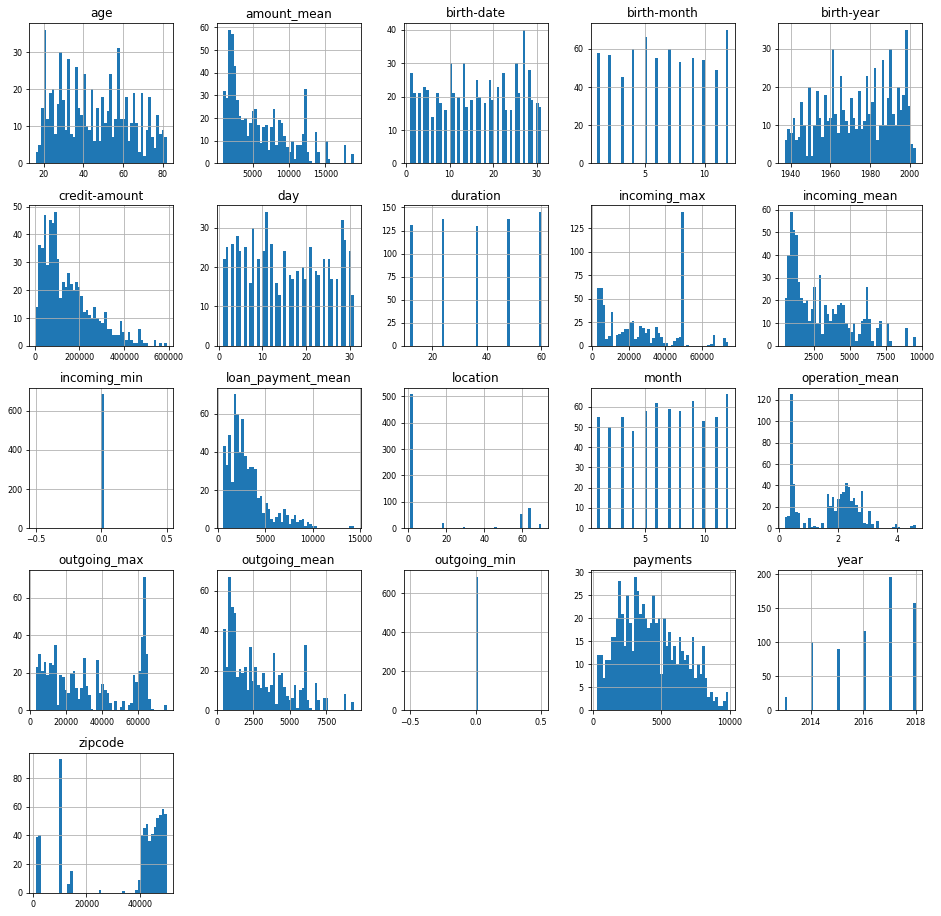

In [39]:
#Data insights
data_check(df)
insights(df)
statistics(df)

In [43]:
#Change formats to dates
df['fulldate'] = df['fulldate'].astype('datetime64[ns]')
df['birthdate'] = df['birthdate'].astype('datetime64')
##fulltime???; 

In [44]:
#Brief statistic for numeric attributes
statistic_num = df[['credit-amount', 'duration', 'payments', 'year', 'age']]
statistic_num.describe()

,credit-amount,duration,payments,year,age
count,682.000000,682.000000,682.000000,682.000000,682.000000
mean,151410.175953,36.492669,4190.664223,2016.234604,45.928152
std,113372.406310,17.075219,2215.830344,1.466445,17.997939
min,4980.000000,12.000000,304.000000,2013.000000,16.000000
25%,66732.000000,24.000000,2477.000000,2015.000000,30.000000
50%,116928.000000,36.000000,3934.000000,2017.000000,45.000000
75%,210654.000000,48.000000,5813.500000,2017.000000,60.000000
max,590820.000000,60.000000,9910.000000,2018.000000,82.000000


In [45]:
#Brief statistic for objects' attributes 
statistic_obj = df[['status', 'purpose', 'sex', 'email', 'city']]
statistic_obj.describe(include=['object'])

,status,purpose,sex,email,city
count,682,682,682,682,682
unique,4,4,2,4,75
top,C,home,Male,gmail.com,New York City
freq,403,537,351,434,84


In [46]:
#Brief statistic for objects' attributes 
df.describe(include=['object'])

,status,purpose,sex,social,first,middle,last,phone,email,address_1,city,state
count,682,682,682,682,682,682,682,682,682,682,682,682
unique,4,4,2,682,669,677,369,682,4,682,75,51
top,C,home,Male,924-23-0125,Rowan,Madison,Little,628-210-0276,gmail.com,9174 Hall Ave.,New York City,NY
freq,403,537,351,1,2,2,2,1,434,1,84,114


In [47]:
#The attribute 'purpose' is the target value. Expanding its distribution and see on what customers commonly take credits.
df['purpose'].value_counts()

home                  537
debt_consolidation     75
home_improvement       40
car                    30
Name: purpose, dtype: int64

In [48]:
df['purpose'].value_counts(normalize=True)

home                  0.787390
debt_consolidation    0.109971
home_improvement      0.058651
car                   0.043988
Name: purpose, dtype: float64

In [49]:
#Mainly people take credits for home in banks and the rest are for some urgent cases

In [50]:
df.sort_values(by='credit-amount', ascending=False).head()

,credit-amount,duration,payments,status,year,month,day,fulldate,location,purpose,amount_mean,operation_mean,incoming_mean,outgoing_mean,incoming_max,outgoing_max,incoming_min,outgoing_min,loan_payment_mean,sex,birthdate,birth-date,birth-month,birth-year,age,social,first,middle,last,phone,email,address_1,city,state,zipcode
681,590820,60,9847,C,2017,10,19,2017-10-19,1,home,1507.693823,2.25,771.509182,736.184641,11400.0,16800.0,0.0,-0.0,3803.40,Male,1990-10-08,8,10,1990,29,182-95-8261,Desmond,Devante,Griffith,163-034-9224,hotmail.com,498 Albany Street,Des Moines,IA,48004
680,566640,60,9444,C,2018,1,23,2018-01-23,1,home,4808.485832,2.02,2456.595483,2351.890349,21739.5,57100.0,0.0,-0.0,3803.40,Female,2000-03-29,29,3,2000,19,869-33-9702,Rowan,Katie,Steele,240-698-9725,outlook.com,68 Highland St.,Kansas City,MO,47471
679,541200,60,9020,D,2017,11,12,2017-11-12,59,home,1718.585890,0.45,886.858896,831.726994,4042.0,4150.0,0.0,-0.0,3803.40,Male,1982-12-04,4,12,1982,37,558-20-4702,Atticus,Crue,Le,466-804-7095,gmail.com,638 N. 3rd Ave.,Houston,TX,44825
678,538500,60,8975,C,2015,2,17,2015-02-17,64,home,2039.438753,0.41,1051.888076,987.550678,5298.0,5950.0,0.0,-0.0,1291.75,Female,1983-08-16,16,8,1983,36,704-97-5207,Haven,Lexi,Schwartz,508-056-6464,gmail.com,9650 Orchard St.,Worcester,MA,1603
677,504000,60,8400,C,2018,1,20,2018-01-20,18,home,1340.523077,0.42,705.407407,635.115670,3399.0,8820.0,0.0,-0.0,1291.75,Male,1945-11-28,28,11,1945,74,423-50-5098,Allen,Camari,Cortez,424-700-9334,outlook.com,40 College Dr.,Minneapolis,MN,47667


In [51]:
#Identifying the average values of numerical attributes for distribution amoung target values.

In [52]:
df[df['purpose'] == 'home'].mean()

credit-amount        182298.435754
duration                 40.044693
payments               4755.968343
year                   2016.240223
month                     6.614525
day                      15.547486
location                 15.621974
amount_mean            6053.048769
operation_mean            1.731173
incoming_mean          3087.766004
outgoing_mean          2965.282765
incoming_max          27533.714153
outgoing_max          34757.914339
incoming_min              0.000000
outgoing_min              0.000000
loan_payment_mean      3122.413780
birth-date               15.901304
birth-month               6.510242
birth-year             1973.031657
age                      46.063315
zipcode               34231.325885
dtype: float64

In [53]:
df[df['purpose'] == 'debt_consolidation'].mean()

credit-amount        39901.920000
duration                23.680000
payments              2225.533333
year                  2016.253333
month                    7.213333
day                     14.800000
location                12.306667
amount_mean           6413.898465
operation_mean           1.715600
incoming_mean         3270.243949
outgoing_mean         3143.654516
incoming_max         27000.366667
outgoing_max         34885.520000
incoming_min             0.000000
outgoing_min             0.000000
loan_payment_mean     2700.004800
birth-date              17.346667
birth-month              6.986667
birth-year            1972.986667
age                     46.080000
zipcode              37819.773333
dtype: float64

In [54]:
df[df['purpose'] == 'home_improvement'].mean()

credit-amount        46853.400000
duration                21.300000
payments              2776.850000
year                  2016.200000
month                    6.050000
day                     15.925000
location                14.250000
amount_mean           4955.266356
operation_mean           1.628000
incoming_mean         2533.290127
outgoing_mean         2421.976229
incoming_max         22551.487500
outgoing_max         28134.750000
incoming_min             0.000000
outgoing_min             0.000000
loan_payment_mean     2940.694750
birth-date              18.525000
birth-month              6.325000
birth-year            1975.125000
age                     43.950000
zipcode              32916.575000
dtype: float64

In [55]:
df[df['purpose'] == 'car'].mean()

credit-amount        16690.000000
duration                25.200000
payments               869.633333
year                  2016.133333
month                    7.000000
day                     14.633333
location                13.166667
amount_mean           4331.404293
operation_mean           1.363000
incoming_mean         2214.049958
outgoing_mean         2117.354335
incoming_max         17784.383333
outgoing_max         24725.666667
incoming_min             0.000000
outgoing_min             0.000000
loan_payment_mean     3604.648333
birth-date              16.066667
birth-month              6.400000
birth-year            1973.366667
age                     45.766667
zipcode              31771.233333
dtype: float64

In [56]:
#Selecting the destribution of gender for credit for homes

In [57]:
"{:.2f}".format(df[(df['purpose'] == 'home') & (df['sex'] == 'Male')]['credit-amount'].mean())

'186670.23'

In [58]:
"{:.2f}".format(df[(df['purpose'] == 'home') & (df['sex'] == 'Female')]['credit-amount'].mean())

'177605.93'

In [59]:
#Men take credit for larger amount of money

In [60]:
#Reveals statistics of females
df[df['sex'].apply(lambda state: state[0] == 'F')].head()

,credit-amount,duration,payments,status,year,month,day,fulldate,location,purpose,amount_mean,operation_mean,incoming_mean,outgoing_mean,incoming_max,outgoing_max,incoming_min,outgoing_min,loan_payment_mean,sex,birthdate,birth-date,birth-month,birth-year,age,social,first,middle,last,phone,email,address_1,city,state,zipcode
0,4980,12,415,A,2014,7,5,2014-07-05,59,car,12220.620460,2.78,6217.608966,6003.011494,49753.0,63900.0,0.0,-0.0,2452.00,Female,1990-12-13,13,12,1990,29,926-93-2157,Emma,Avaya,Smith,367-171-6840,gmail.com,387 Wellington Ave.,Albuquerque,NM,47246
2,7656,24,319,A,2014,3,30,2014-03-30,1,car,5584.319833,1.82,2877.421712,2706.898121,26216.0,37800.0,0.0,-0.0,5319.35,Female,1960-10-09,9,10,1960,59,614-70-9100,Olivia,Brooklynne,Johnson,212-425-6932,outlook.com,36 Second St.,New York City,NY,10162
4,10944,36,304,C,2018,5,17,2018-05-17,1,car,2039.438753,0.41,1051.888076,987.550678,5298.0,5950.0,0.0,-0.0,1667.00,Female,1980-07-03,3,7,1980,39,536-14-5809,Sophia,Danae,Williams,428-265-1568,gmail.com,755 Galvin Street,Indianapolis,IN,40852
7,12540,12,1045,A,2017,11,28,2017-11-28,64,debt_consolidation,3786.018421,1.68,1928.901316,1857.117105,22168.0,24300.0,0.0,-0.0,1681.50,Female,1958-02-21,21,2,1958,61,425-96-6358,Ava,Eliora,Brown,413-444-9280,gmail.com,817 Joy Ridge Dr.,Springfield,MA,1101
10,14628,12,1219,A,2014,8,4,2014-08-04,1,car,3705.990864,1.81,1881.437375,1824.553488,20950.0,31840.0,0.0,-0.0,4880.00,Female,1970-08-22,22,8,1970,49,666-36-2990,Isabella,Haidyn,Jones,508-688-6461,hotmail.com,873 Randall Mill Dr.,New Bedford,MA,2741


In [61]:
#Feature creation
df['duration'].unique()

array([12, 24, 36, 48, 60])

In [62]:
#Creating new feature as it can be more usefull in terms of model
df['credit-year'] = df['duration'] / 12

In [63]:
#Adding the Serie to df DataFrame
df = df.append(df['credit-year'])

In [64]:
#As there is glitch in Python and columns are duplicated, there is need to remove unqualified data
df = df.drop(columns = df.iloc[:, 36:719])
df = df.drop(labels = 'credit-year')

In [65]:
#to check for how long people take credits for different purposes
df.groupby(['purpose'])['duration', 'age'].agg([np.mean, np.median, np.std, np.min, np.max])

/Users/amihailovs/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


duration                                      age         \
                         mean median        std  amin  amax       mean median   
purpose                                                                         
car                 25.200000   24.0  15.227924  12.0  60.0  45.766667   47.5   
debt_consolidation  23.680000   12.0  15.404597  12.0  60.0  46.080000   42.0   
home                40.044693   36.0  15.874445  12.0  60.0  46.063315   45.0   
home_improvement    21.300000   12.0  13.447333  12.0  60.0  43.950000   41.5   

                                           
                          std  amin  amax  
purpose                                    
car                 18.182377  18.0  80.0  
debt_consolidation  18.076235  19.0  81.0  
home                17.912195  16.0  82.0  
home_improvement    19.403872  19.0  78.0

In [66]:
#to check the distribution amoung genders
pd.crosstab(df['purpose'], df['sex'])

sex,Female,Male
purpose,,
car,17,17
debt_consolidation,17,17
home,17,17
home_improvement,17,17


In [67]:
pd.crosstab(df['purpose'], df['sex'], normalize=True)

sex,Female,Male
purpose,,
car,0.125,0.125
debt_consolidation,0.125,0.125
home,0.125,0.125
home_improvement,0.125,0.125


In [68]:
#Female prefers credits for cars and home improvements while men debt consolidations and homes

In [69]:
#The next step is to check the average payments for each of the product
"{:.2f}".format(df[df['purpose'] == 'home']['payments'].mean())

'4755.97'

In [70]:
"{:.2f}".format(df[df['purpose'] == 'car']['payments'].mean())

'869.63'

In [71]:
"{:.2f}".format(df[df['purpose'] == 'debt_consolidation']['payments'].mean())

'2225.53'

In [72]:
"{:.2f}".format(df[df['purpose'] == 'home_improvement']['payments'].mean())

'2776.85'

In [73]:
#The highest is home and lowest is a car. 
#People usually are ready to pay almost the same amount of money for debt consolidation and for improving their homes.

In [74]:
'''Features'''

'Features'

In [75]:
#Checking age for changing it into groups
df['age'].value_counts(sort=True)

57.0    22
21.0    22
29.0    21
32.0    19
23.0    19
        ..
68.0     3
82.0     2
71.0     2
17.0     2
16.0     1
Name: age, Length: 67, dtype: int64

<AxesSubplot:xlabel='age'>

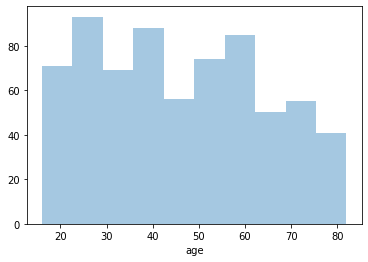

In [76]:
sns.distplot(a=df['age'], kde = False)

In [77]:
#The age can be grouped into chans as additional feature.
#The bins can be devided into real-life categories such as student or pensioner.
#Diveding into groups is in accordance to Canadian Statistic's Life Cycle.
#https://www.statcan.gc.ca/eng/concepts/definitions/age2

In [78]:
cut_labels_1 = ['1', '2', '3']
cut_bins1 = [15, 24, 64, 120]
df['Life-Cycle'] = pd.cut(df['age'], bins=cut_bins1, labels = cut_labels_1)
#1 - Youth (15-24 years)
#2 - Adults (25-64 years)
#3 - Seniors (65 years and over)

In [79]:
df['Life-Cycle'].unique()

[2, 3, 1]
Categories (3, object): [1 < 2 < 3]

In [80]:
#One more feature will be for grouping into generations according to the WEF article:
#https://www.weforum.org/agenda/2015/09/how-different-age-groups-identify-with-their-generational-labels/
#Grouped as per these data

In [81]:
cut_labels_1 = ['10', '20', '25', '30', '40']
cut_bins1 = [5, 25, 30, 40, 55, 120]
df['Generation'] = pd.cut(df['age'], bins=cut_bins1, labels = cut_labels_1)
#1 - Gen Z(5-25)
#2 - Gen Y.1(26-30)
#2.5 - Gen Y.2(31-40)
#3 - Gen X(41-55)
#4 - Baby Boomers(56-)
#As such assigned numbers cannot be integers, but only float, because of Gen Y is devided into two groups, these numbers are multipled by 10. 

In [82]:
#Regardless some people belonging to youth are not students, 
#anyway that mean that their working experience is not high that reflects on the salary.

In [83]:
#Setting for vizualization
#Disable Anaconda warnings
import warnings
warnings.simplefilter('ignore')

# will display the graphs directly in Jupyter
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#svg graphics look sharper
%config InlineBackend.figure_format = 'svg' 

#increase the default chart size for readability
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
import pandas as pd

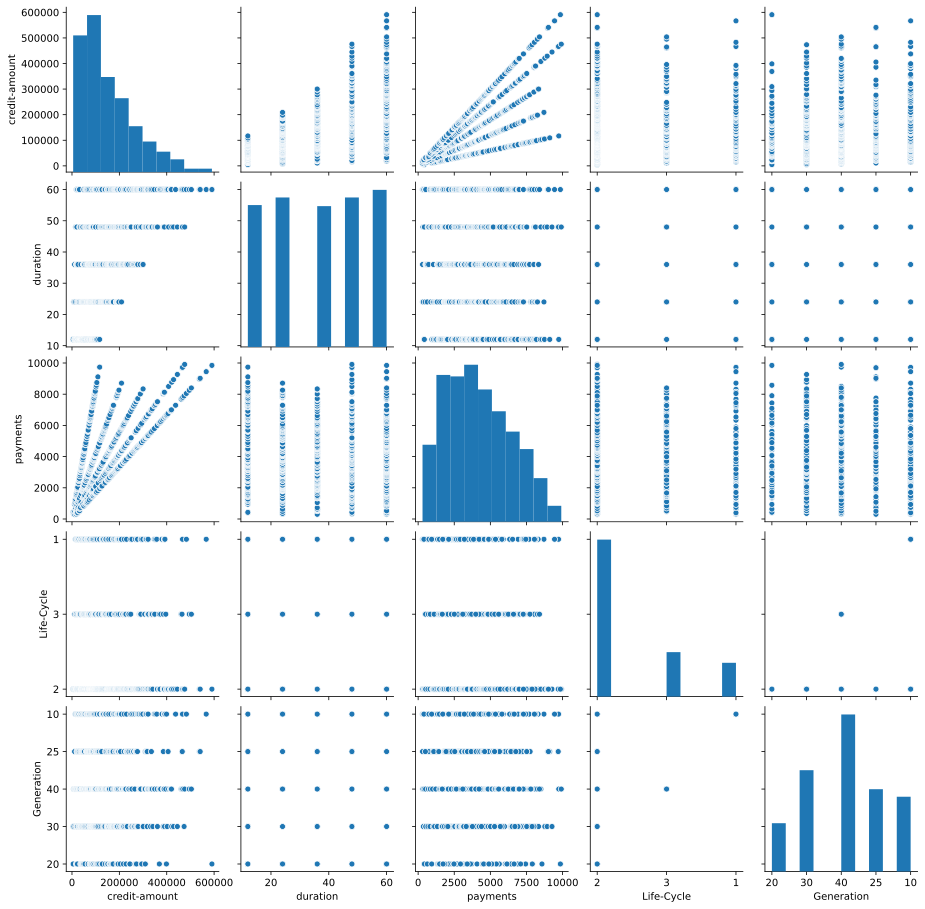

In [84]:
#This visualization will help us look at one picture of how the various features are related.
cols = ['credit-amount', 'duration', 'payments', 'status', 'fulldate', 'purpose', 'Life-Cycle', 'Generation']
sns_plot = sns.pairplot(df[cols])

<AxesSubplot:xlabel='age', ylabel='purpose'>

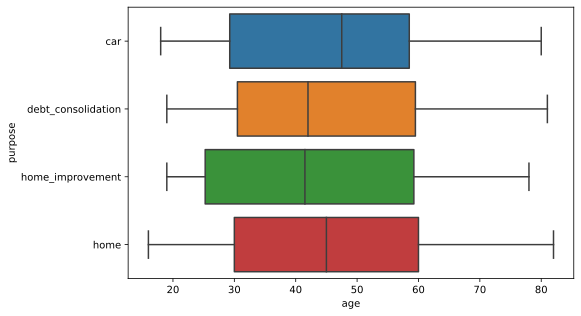

In [85]:
#Comparison of credits for the age group
top_platforms = df.payments.value_counts().sort_values(ascending = False).index.values
sns.boxplot(y="purpose", x="age", data=df[df.payments.isin(top_platforms)], orient="h")

<AxesSubplot:xlabel='year', ylabel='purpose'>

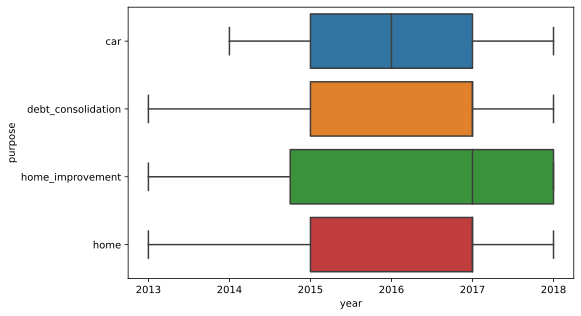

In [86]:
top_platforms = df.payments.value_counts().sort_values(ascending = False).index.values
sns.boxplot(y="purpose", x="year", data=df[df.payments.isin(top_platforms)], orient="h")

<AxesSubplot:xlabel='sex', ylabel='purpose'>

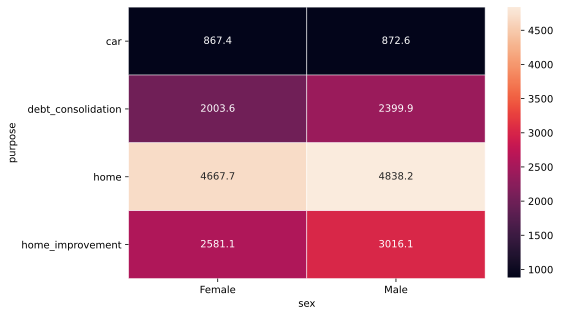

In [87]:
#Heat map for two categorical feaеtures. This allows you to look at the distribution of a 
#numerical attribute according to two categorical ones. We visualize the total payments for credits and generations
platform_genre_sales = df.pivot_table(
                        index='purpose', 
                        columns='sex', 
                        values='payments', 
                        aggfunc=np.mean).fillna(0).applymap(float)
sns.heatmap(platform_genre_sales, annot=True, fmt=".1f", linewidths=.5)

<AxesSubplot:xlabel='Life-Cycle', ylabel='purpose'>

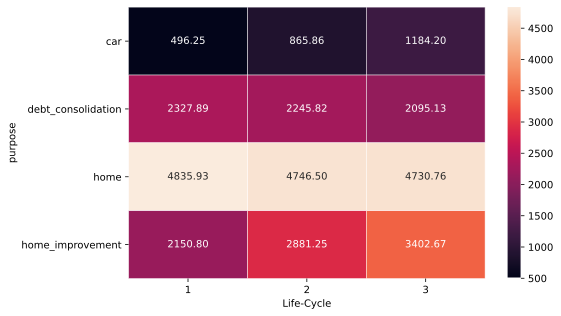

In [88]:
platform_genre_sales = df.pivot_table(
                        index='purpose', 
                        columns='Life-Cycle', 
                        values='payments', 
                        aggfunc=np.mean).fillna(0).applymap(float)
sns.heatmap(platform_genre_sales, annot=True, fmt=".2f", linewidths=.5)

In [89]:
#Youth are able to pay more for their home, however, the are considerably less take credits for home improvements in comparison to more adult people. 

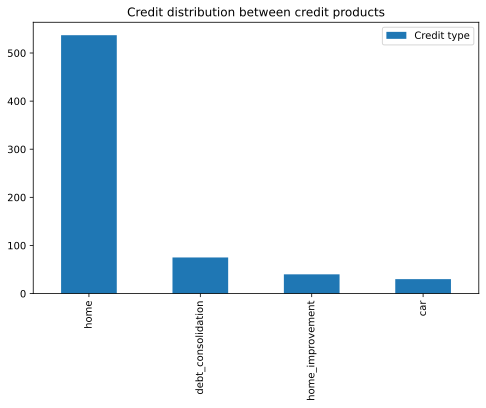

In [90]:
df['purpose'].value_counts().plot(kind='bar', label='Credit type')
plt.legend()
plt.title('Credit distribution between credit products');

In [91]:
#Look at the distribution of all the quantitative traits. 

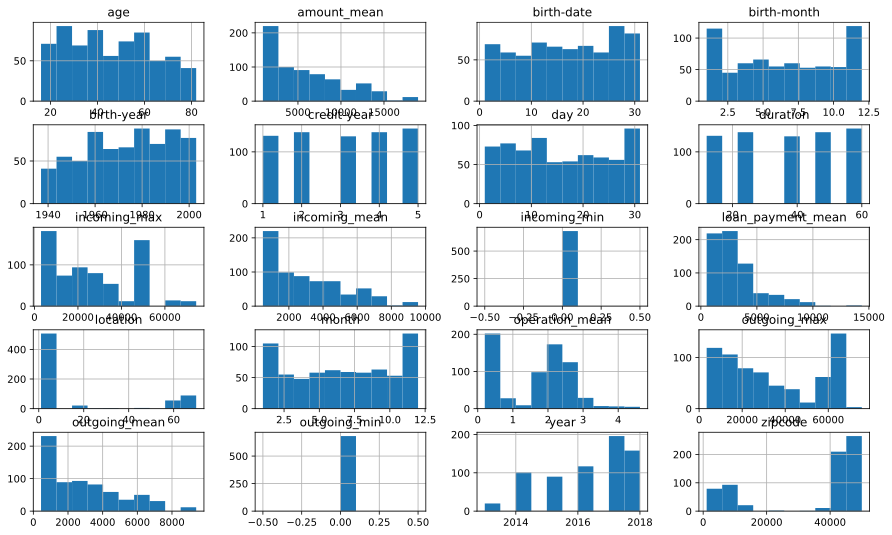

In [92]:
features = list(set(df.columns) - set(['credit-amount', 'payments', 'purpose',  'status',
                                      'sex']))

df[features].hist(figsize=(15,9));

In [93]:
#It is seen that most of the signs are distributed normally which are needed for the model.

In [94]:
from datetime import date

In [95]:
df['delta'] = df['fulldate'] - df['birthdate']

In [96]:
df['delta']

0      8605 days
1     19471 days
2     19530 days
3     14909 days
4     13832 days
         ...    
677   26351 days
678   11508 days
679   12762 days
680    6509 days
681    9873 days
Name: delta, Length: 682, dtype: timedelta64[ns]

In [97]:
### Feature Status

In [98]:
df['status'].value_counts()

C    403
A    203
D     45
B     31
Name: status, dtype: int64

In [99]:
#changing object into numberic categorical attribute
from sklearn.preprocessing import LabelEncoder

In [100]:
label_encoder = LabelEncoder()
for status in df:
    df['status'] = label_encoder.fit_transform(df['status'])

In [101]:
label_encoder = LabelEncoder()
for status in df:
    df['purpose'] = label_encoder.fit_transform(df['purpose'])

In [102]:
df = df.drop('fulldate', axis=1)

In [103]:
#Changing attribute type to more appropriate from float to integers 
df['credit-amount'] = df['credit-amount'].astype(int)
df['duration'] = df['duration'].astype(int)
df['payments'] = df['payments'].astype(int)
df['year'] = df['year'].astype(int)
df['month'] = df['month'].astype(int)
df['day'] = df['day'].astype(int)
df['location'] = df['location'].astype(int)
df['Life-Cycle'] = df['Life-Cycle'].astype(int)
df['Generation'] = df['Generation'].astype(int)
df['delta'] = df['delta'].astype(int)

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 682 entries, 0 to 681
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   credit-amount      682 non-null    int64         
 1   duration           682 non-null    int64         
 2   payments           682 non-null    int64         
 3   status             682 non-null    int64         
 4   year               682 non-null    int64         
 5   month              682 non-null    int64         
 6   day                682 non-null    int64         
 7   location           682 non-null    int64         
 8   purpose            682 non-null    int64         
 9   amount_mean        682 non-null    float64       
 10  operation_mean     682 non-null    float64       
 11  incoming_mean      682 non-null    float64       
 12  outgoing_mean      682 non-null    float64       
 13  incoming_max       682 non-null    float64       
 14  outgoing_max   

# Additonal feature creation

In [105]:
df.head()

,credit-amount,duration,payments,status,year,month,day,location,purpose,amount_mean,operation_mean,incoming_mean,outgoing_mean,incoming_max,outgoing_max,incoming_min,outgoing_min,loan_payment_mean,sex,birthdate,birth-date,birth-month,birth-year,age,social,first,middle,last,phone,email,address_1,city,state,zipcode,credit-year,Life-Cycle,Generation,delta
0,4980,12,415,0,2014,7,5,59,0,12220.620460,2.78,6217.608966,6003.011494,49753.0,63900.0,0.0,-0.0,2452.00,Female,1990-12-13,13.0,12.0,1990.0,29.0,926-93-2157,Emma,Avaya,Smith,367-171-6840,gmail.com,387 Wellington Ave.,Albuquerque,NM,47246.0,1.0,2,20,743472000000000000
1,5148,12,429,2,2018,5,28,1,0,2445.863966,0.42,1272.584078,1173.279888,6207.0,12500.0,0.0,-0.0,5319.35,Male,1965-02-04,4.0,2.0,1965.0,54.0,806-94-5725,Noah,Everest,Thompson,212-423-7734,gmail.com,75 W. Berkshire St.,New York City,NY,10040.0,1.0,2,30,1682294400000000000
2,7656,24,319,0,2014,3,30,1,0,5584.319833,1.82,2877.421712,2706.898121,26216.0,37800.0,0.0,-0.0,5319.35,Female,1960-10-09,9.0,10.0,1960.0,59.0,614-70-9100,Olivia,Brooklynne,Johnson,212-425-6932,outlook.com,36 Second St.,New York City,NY,10162.0,2.0,2,40,1687392000000000000
3,8616,24,359,2,2017,9,26,1,0,4916.421786,1.83,2513.746429,2402.675357,26049.0,38080.0,0.0,-0.0,1667.00,Male,1976-12-01,1.0,12.0,1976.0,43.0,580-20-3414,Liam,Irvin,White,951-567-8925,gmail.com,7607 Sunnyslope Street,Indianapolis,IN,49047.0,2.0,2,30,1288137600000000000
4,10944,36,304,2,2018,5,17,1,0,2039.438753,0.41,1051.888076,987.550678,5298.0,5950.0,0.0,-0.0,1667.00,Female,1980-07-03,3.0,7.0,1980.0,39.0,536-14-5809,Sophia,Danae,Williams,428-265-1568,gmail.com,755 Galvin Street,Indianapolis,IN,40852.0,3.0,2,25,1195084800000000000


In [106]:
#Decreasing the size of number
df['duration-year'] = df['duration'] / 12
df['duration-year'].astype(int)

0      1
1      1
2      2
3      2
4      3
      ..
677    5
678    5
679    5
680    5
681    5
Name: duration-year, Length: 682, dtype: int64

In [107]:
#Transofrming continuous numeric feature

In [108]:
df['payments'] = df['payments'].astype(int)

In [109]:
df['payments-dif'] = df['payments'] / 100

<AxesSubplot:xlabel='payments-dif'>

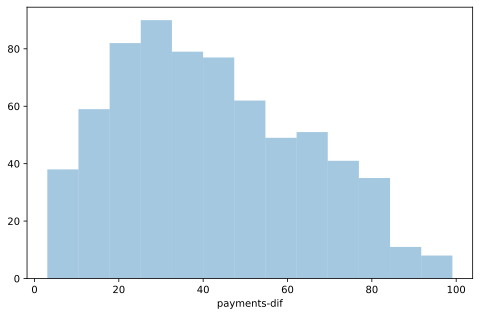

In [110]:
sns.distplot(a=df['payments-dif'], kde = False)

<AxesSubplot:xlabel='payments'>

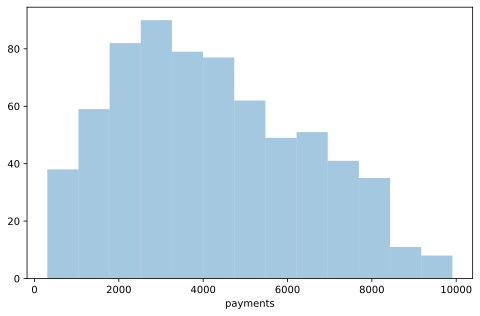

In [111]:
sns.distplot(a=df['payments'], kde = False)

In [112]:
#df['payments'].hist(range=100, figsize=(15,9));

<AxesSubplot:xlabel='payments'>

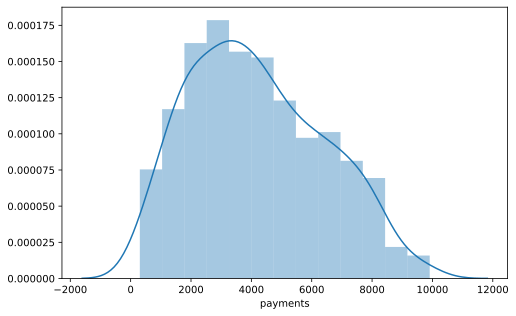

In [113]:
sns.distplot(df['payments'], hist=True)

In [114]:
df['payments'].value_counts(sort=True, ascending=True, normalize=True, bins=4)

(7508.5, 9910.0]                0.090909
(5107.0, 7508.5]                0.244868
(294.39300000000003, 2705.5]    0.291789
(2705.5, 5107.0]                0.372434
Name: payments, dtype: float64

The splitting of numerical features can be performed by sorting the features in the ascending order and trying each value as the threshold point and calculating the information gain for each value as the threshold. 

In [115]:
#As Tree-based models are not really influenced by scaling, the column of payments should be binned into part. 

In [116]:
df['payments'] = df['payments'].astype(int)

In [117]:
df['popularity_scale_10'] = np.array(
                   np.round((df['payments'] * 10)),  
                   dtype='int')
df['popularity_scale_100'] = np.array(
                  np.round((df['payments'] * 100)),    
                  dtype='int')

In [118]:
df

,credit-amount,duration,payments,status,year,month,day,location,purpose,amount_mean,operation_mean,incoming_mean,outgoing_mean,incoming_max,outgoing_max,incoming_min,outgoing_min,loan_payment_mean,sex,birthdate,birth-date,birth-month,birth-year,age,social,first,middle,last,phone,email,address_1,city,state,zipcode,credit-year,Life-Cycle,Generation,delta,duration-year,payments-dif,popularity_scale_10,popularity_scale_100
0,4980,12,415,0,2014,7,5,59,0,12220.620460,2.78,6217.608966,6003.011494,49753.0,63900.0,0.0,-0.0,2452.00,Female,1990-12-13,13.0,12.0,1990.0,29.0,926-93-2157,Emma,Avaya,Smith,367-171-6840,gmail.com,387 Wellington Ave.,Albuquerque,NM,47246.0,1.0,2,20,743472000000000000,1.0,4.15,4150,41500
1,5148,12,429,2,2018,5,28,1,0,2445.863966,0.42,1272.584078,1173.279888,6207.0,12500.0,0.0,-0.0,5319.35,Male,1965-02-04,4.0,2.0,1965.0,54.0,806-94-5725,Noah,Everest,Thompson,212-423-7734,gmail.com,75 W. Berkshire St.,New York City,NY,10040.0,1.0,2,30,1682294400000000000,1.0,4.29,4290,42900
2,7656,24,319,0,2014,3,30,1,0,5584.319833,1.82,2877.421712,2706.898121,26216.0,37800.0,0.0,-0.0,5319.35,Female,1960-10-09,9.0,10.0,1960.0,59.0,614-70-9100,Olivia,Brooklynne,Johnson,212-425-6932,outlook.com,36 Second St.,New York City,NY,10162.0,2.0,2,40,1687392000000000000,2.0,3.19,3190,31900
3,8616,24,359,2,2017,9,26,1,0,4916.421786,1.83,2513.746429,2402.675357,26049.0,38080.0,0.0,-0.0,1667.00,Male,1976-12-01,1.0,12.0,1976.0,43.0,580-20-3414,Liam,Irvin,White,951-567-8925,gmail.com,7607 Sunnyslope Street,Indianapolis,IN,49047.0,2.0,2,30,1288137600000000000,2.0,3.59,3590,35900
4,10944,36,304,2,2018,5,17,1,0,2039.438753,0.41,1051.888076,987.550678,5298.0,5950.0,0.0,-0.0,1667.00,Female,1980-07-03,3.0,7.0,1980.0,39.0,536-14-5809,Sophia,Danae,Williams,428-265-1568,gmail.com,755 Galvin Street,Indianapolis,IN,40852.0,3.0,2,25,1195084800000000000,3.0,3.04,3040,30400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,504000,60,8400,2,2018,1,20,18,2,1340.523077,0.42,705.407407,635.115670,3399.0,8820.0,0.0,-0.0,1291.75,Male,1945-11-28,28.0,11.0,1945.0,74.0,423-50-5098,Allen,Camari,Cortez,424-700-9334,outlook.com,40 College Dr.,Minneapolis,MN,47667.0,5.0,3,40,2276726400000000000,5.0,84.00,84000,840000
678,538500,60,8975,2,2015,2,17,64,2,2039.438753,0.41,1051.888076,987.550678,5298.0,5950.0,0.0,-0.0,1291.75,Female,1983-08-16,16.0,8.0,1983.0,36.0,704-97-5207,Haven,Lexi,Schwartz,508-056-6464,gmail.com,9650 Orchard St.,Worcester,MA,1603.0,5.0,2,25,994291200000000000,5.0,89.75,89750,897500
679,541200,60,9020,3,2017,11,12,59,2,1718.585890,0.45,886.858896,831.726994,4042.0,4150.0,0.0,-0.0,3803.40,Male,1982-12-04,4.0,12.0,1982.0,37.0,558-20-4702,Atticus,Crue,Le,466-804-7095,gmail.com,638 N. 3rd Ave.,Houston,TX,44825.0,5.0,2,25,1102636800000000000,5.0,90.20,90200,902000
680,566640,60,9444,2,2018,1,23,1,2,4808.485832,2.02,2456.595483,2351.890349,21739.5,57100.0,0.0,-0.0,3803.40,Female,2000-03-29,29.0,3.0,2000.0,19.0,869-33-9702,Rowan,Katie,Steele,240-698-9725,outlook.com,68 Highland St.,Kansas City,MO,47471.0,5.0,1,10,562377600000000000,5.0,94.44,94440,944400


The clear strategy for dividing payments into bins were not found out. Therefore, one of the options is to separete per equil quantiles. In order to not make it highly correlated with 'credit-amount' groups, the deviding is into four groups, not for to. If two attributes will be highly correclated, there is high-chance for overfitting. 

In [119]:
quantile_list = [0, .25, .5, .75, 1.]
quantiles = df['payments'].quantile(quantile_list)
quantiles

0.00     304.0
0.25    2477.0
0.50    3934.0
0.75    5813.5
1.00    9910.0
Name: payments, dtype: float64

In [120]:
quantile_labels = ['25', '50', '75', '100']
df['Income_quantile_range'] = pd.qcut(
                                            df['payments'], 
                                            q=quantile_list)
df['Income_quantile_label'] = pd.qcut(
                                            df['payments'], 
                                            q=quantile_list,       
                                            labels=quantile_labels)

<AxesSubplot:xlabel='credit-amount'>

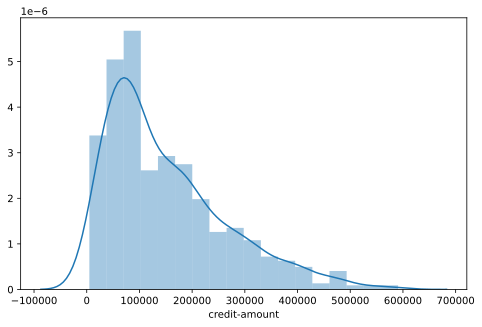

In [121]:
sns.distplot(df['credit-amount'], hist=True)

Distribution is skewed to the left side. As the major amount of credits is allocated to 100.000 USD, the continous numberic attribate can be devided into two groups. 

In [122]:
cut_labels_1 = ['1', '2']
cut_bins1 = [0, 100000, 700000]
df['credit-amount-gr'] = pd.cut(df['credit-amount'], bins=cut_bins1, labels = cut_labels_1)

In [123]:
df['credit-amount-gr'] = df['credit-amount-gr'].astype(int)

In [124]:
#Credit amount is feature for those clients who already took a credit
#Pearson's correlation matrix
plt.figure(figsize=(20,12))
sns.heatmap(data=X.corr(method='pearson'), annot=True,cmap="YlGnBu")

plt.savefig('correlation.png')

NameError: name 'X' is not defined

<Figure size 1440x864 with 0 Axes>

<AxesSubplot:xlabel='credit-amount-gr', ylabel='status'>

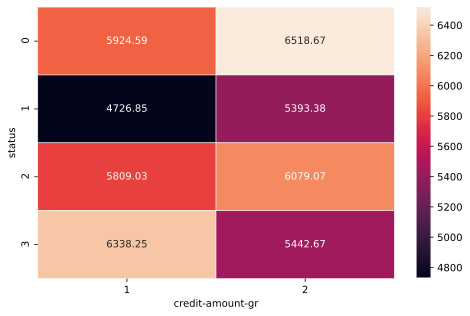

In [125]:
platform_genre_sales = df.pivot_table(
                        index='status', 
                        columns='credit-amount-gr', 
                        values='amount_mean', 
                        aggfunc=np.mean).fillna(0).applymap(float)
sns.heatmap(platform_genre_sales, annot=True, fmt=".2f", linewidths=.5)

The table 'credit-amount-gr' has low correclation with the other tables. In closer look of correlation between 'status' and 'credit-amount-gr' for transactions there is no significant difference. Therefore, the feature requires more deep investigation and experiments or simply removed.

In [126]:
#Gender transformation
#One of the options is to transofrm Gender column with hot encoding as the are no lots of values. 

In [127]:
onehot_gender = pd.get_dummies(df['sex'])

In [128]:
df = df.join(onehot_gender)

In [129]:
df

,credit-amount,duration,payments,status,year,month,day,location,purpose,amount_mean,operation_mean,incoming_mean,outgoing_mean,incoming_max,outgoing_max,incoming_min,outgoing_min,loan_payment_mean,sex,birthdate,birth-date,birth-month,birth-year,age,social,first,middle,last,phone,email,address_1,city,state,zipcode,credit-year,Life-Cycle,Generation,delta,duration-year,payments-dif,popularity_scale_10,popularity_scale_100,Income_quantile_range,Income_quantile_label,credit-amount-gr,Female,Male
0,4980,12,415,0,2014,7,5,59,0,12220.620460,2.78,6217.608966,6003.011494,49753.0,63900.0,0.0,-0.0,2452.00,Female,1990-12-13,13.0,12.0,1990.0,29.0,926-93-2157,Emma,Avaya,Smith,367-171-6840,gmail.com,387 Wellington Ave.,Albuquerque,NM,47246.0,1.0,2,20,743472000000000000,1.0,4.15,4150,41500,"(303.999, 2477.0]",25,1,1,0
1,5148,12,429,2,2018,5,28,1,0,2445.863966,0.42,1272.584078,1173.279888,6207.0,12500.0,0.0,-0.0,5319.35,Male,1965-02-04,4.0,2.0,1965.0,54.0,806-94-5725,Noah,Everest,Thompson,212-423-7734,gmail.com,75 W. Berkshire St.,New York City,NY,10040.0,1.0,2,30,1682294400000000000,1.0,4.29,4290,42900,"(303.999, 2477.0]",25,1,0,1
2,7656,24,319,0,2014,3,30,1,0,5584.319833,1.82,2877.421712,2706.898121,26216.0,37800.0,0.0,-0.0,5319.35,Female,1960-10-09,9.0,10.0,1960.0,59.0,614-70-9100,Olivia,Brooklynne,Johnson,212-425-6932,outlook.com,36 Second St.,New York City,NY,10162.0,2.0,2,40,1687392000000000000,2.0,3.19,3190,31900,"(303.999, 2477.0]",25,1,1,0
3,8616,24,359,2,2017,9,26,1,0,4916.421786,1.83,2513.746429,2402.675357,26049.0,38080.0,0.0,-0.0,1667.00,Male,1976-12-01,1.0,12.0,1976.0,43.0,580-20-3414,Liam,Irvin,White,951-567-8925,gmail.com,7607 Sunnyslope Street,Indianapolis,IN,49047.0,2.0,2,30,1288137600000000000,2.0,3.59,3590,35900,"(303.999, 2477.0]",25,1,0,1
4,10944,36,304,2,2018,5,17,1,0,2039.438753,0.41,1051.888076,987.550678,5298.0,5950.0,0.0,-0.0,1667.00,Female,1980-07-03,3.0,7.0,1980.0,39.0,536-14-5809,Sophia,Danae,Williams,428-265-1568,gmail.com,755 Galvin Street,Indianapolis,IN,40852.0,3.0,2,25,1195084800000000000,3.0,3.04,3040,30400,"(303.999, 2477.0]",25,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,504000,60,8400,2,2018,1,20,18,2,1340.523077,0.42,705.407407,635.115670,3399.0,8820.0,0.0,-0.0,1291.75,Male,1945-11-28,28.0,11.0,1945.0,74.0,423-50-5098,Allen,Camari,Cortez,424-700-9334,outlook.com,40 College Dr.,Minneapolis,MN,47667.0,5.0,3,40,2276726400000000000,5.0,84.00,84000,840000,"(5813.5, 9910.0]",100,2,0,1
678,538500,60,8975,2,2015,2,17,64,2,2039.438753,0.41,1051.888076,987.550678,5298.0,5950.0,0.0,-0.0,1291.75,Female,1983-08-16,16.0,8.0,1983.0,36.0,704-97-5207,Haven,Lexi,Schwartz,508-056-6464,gmail.com,9650 Orchard St.,Worcester,MA,1603.0,5.0,2,25,994291200000000000,5.0,89.75,89750,897500,"(5813.5, 9910.0]",100,2,1,0
679,541200,60,9020,3,2017,11,12,59,2,1718.585890,0.45,886.858896,831.726994,4042.0,4150.0,0.0,-0.0,3803.40,Male,1982-12-04,4.0,12.0,1982.0,37.0,558-20-4702,Atticus,Crue,Le,466-804-7095,gmail.com,638 N. 3rd Ave.,Houston,TX,44825.0,5.0,2,25,1102636800000000000,5.0,90.20,90200,902000,"(5813.5, 9910.0]",100,2,0,1
680,566640,60,9444,2,2018,1,23,1,2,4808.485832,2.02,2456.595483,2351.890349,21739.5,57100.0,0.0,-0.0,3803.40,Female,2000-03-29,29.0,3.0,2000.0,19.0,869-33-9702,Rowan,Katie,Steele,240-698-9725,outlook.com,68 Highland St.,Kansas City,MO,47471.0,5.0,1,10,562377600000000000,5.0,94.44,94440,944400,"(5813.5, 9910.0]",100,2,1,0


In [130]:
#'Email' column convertation

The first option is just encode with labels.

In [131]:
#instance creation
label_encoder = LabelEncoder()
#tranformation and storing data into 'email types' column. 
df['email_types'] = label_encoder.fit_transform(df['email'])

The second attempt is to create a frequence encoding for email attribute, then check the feature importance and remove these that influence on the model worse. For simlicity, treating email types as numeric variable, all parts are unique type values,hence, these values will be replaced with average of emails that are grouped by our targer variables. 
Refference: https://www.kaggle.com/dustinthewind/making-sense-of-mean-encoding

In [132]:
encod_type = df.groupby('purpose')['email_types'].mean()
print(encod_type)
df.loc[:, 'type_mean_email'] = df['purpose'].map(encod_type)
df[['purpose','type_mean_email']].head(100)

purpose
0    0.266667
1    0.346667
2    0.774674
3    0.175000
Name: email_types, dtype: float64


,purpose,type_mean_email
0,0,0.266667
1,0,0.266667
2,0,0.266667
3,0,0.266667
4,0,0.266667
...,...,...
95,1,0.346667
96,1,0.346667
97,1,0.346667
98,3,0.175000


In [133]:
def most_frequent_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    items = []
    vals = []
    for col in data.columns:
        itm = data[col].value_counts().index[0]
        val = data[col].value_counts().values[0]
        items.append(itm)
        vals.append(val)
    tt['Most frequent item'] = items
    tt['Frequence'] = vals
    tt['Percent from total'] = np.round(vals / total * 100, 3)
    return(np.transpose(tt))

In [134]:
df

,credit-amount,duration,payments,status,year,month,day,location,purpose,amount_mean,operation_mean,incoming_mean,outgoing_mean,incoming_max,outgoing_max,incoming_min,outgoing_min,loan_payment_mean,sex,birthdate,birth-date,birth-month,birth-year,age,social,first,middle,last,phone,email,address_1,city,state,zipcode,credit-year,Life-Cycle,Generation,delta,duration-year,payments-dif,popularity_scale_10,popularity_scale_100,Income_quantile_range,Income_quantile_label,credit-amount-gr,Female,Male,email_types,type_mean_email
0,4980,12,415,0,2014,7,5,59,0,12220.620460,2.78,6217.608966,6003.011494,49753.0,63900.0,0.0,-0.0,2452.00,Female,1990-12-13,13.0,12.0,1990.0,29.0,926-93-2157,Emma,Avaya,Smith,367-171-6840,gmail.com,387 Wellington Ave.,Albuquerque,NM,47246.0,1.0,2,20,743472000000000000,1.0,4.15,4150,41500,"(303.999, 2477.0]",25,1,1,0,0,0.266667
1,5148,12,429,2,2018,5,28,1,0,2445.863966,0.42,1272.584078,1173.279888,6207.0,12500.0,0.0,-0.0,5319.35,Male,1965-02-04,4.0,2.0,1965.0,54.0,806-94-5725,Noah,Everest,Thompson,212-423-7734,gmail.com,75 W. Berkshire St.,New York City,NY,10040.0,1.0,2,30,1682294400000000000,1.0,4.29,4290,42900,"(303.999, 2477.0]",25,1,0,1,0,0.266667
2,7656,24,319,0,2014,3,30,1,0,5584.319833,1.82,2877.421712,2706.898121,26216.0,37800.0,0.0,-0.0,5319.35,Female,1960-10-09,9.0,10.0,1960.0,59.0,614-70-9100,Olivia,Brooklynne,Johnson,212-425-6932,outlook.com,36 Second St.,New York City,NY,10162.0,2.0,2,40,1687392000000000000,2.0,3.19,3190,31900,"(303.999, 2477.0]",25,1,1,0,2,0.266667
3,8616,24,359,2,2017,9,26,1,0,4916.421786,1.83,2513.746429,2402.675357,26049.0,38080.0,0.0,-0.0,1667.00,Male,1976-12-01,1.0,12.0,1976.0,43.0,580-20-3414,Liam,Irvin,White,951-567-8925,gmail.com,7607 Sunnyslope Street,Indianapolis,IN,49047.0,2.0,2,30,1288137600000000000,2.0,3.59,3590,35900,"(303.999, 2477.0]",25,1,0,1,0,0.266667
4,10944,36,304,2,2018,5,17,1,0,2039.438753,0.41,1051.888076,987.550678,5298.0,5950.0,0.0,-0.0,1667.00,Female,1980-07-03,3.0,7.0,1980.0,39.0,536-14-5809,Sophia,Danae,Williams,428-265-1568,gmail.com,755 Galvin Street,Indianapolis,IN,40852.0,3.0,2,25,1195084800000000000,3.0,3.04,3040,30400,"(303.999, 2477.0]",25,1,1,0,0,0.266667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,504000,60,8400,2,2018,1,20,18,2,1340.523077,0.42,705.407407,635.115670,3399.0,8820.0,0.0,-0.0,1291.75,Male,1945-11-28,28.0,11.0,1945.0,74.0,423-50-5098,Allen,Camari,Cortez,424-700-9334,outlook.com,40 College Dr.,Minneapolis,MN,47667.0,5.0,3,40,2276726400000000000,5.0,84.00,84000,840000,"(5813.5, 9910.0]",100,2,0,1,2,0.774674
678,538500,60,8975,2,2015,2,17,64,2,2039.438753,0.41,1051.888076,987.550678,5298.0,5950.0,0.0,-0.0,1291.75,Female,1983-08-16,16.0,8.0,1983.0,36.0,704-97-5207,Haven,Lexi,Schwartz,508-056-6464,gmail.com,9650 Orchard St.,Worcester,MA,1603.0,5.0,2,25,994291200000000000,5.0,89.75,89750,897500,"(5813.5, 9910.0]",100,2,1,0,0,0.774674
679,541200,60,9020,3,2017,11,12,59,2,1718.585890,0.45,886.858896,831.726994,4042.0,4150.0,0.0,-0.0,3803.40,Male,1982-12-04,4.0,12.0,1982.0,37.0,558-20-4702,Atticus,Crue,Le,466-804-7095,gmail.com,638 N. 3rd Ave.,Houston,TX,44825.0,5.0,2,25,1102636800000000000,5.0,90.20,90200,902000,"(5813.5, 9910.0]",100,2,0,1,0,0.774674
680,566640,60,9444,2,2018,1,23,1,2,4808.485832,2.02,2456.595483,2351.890349,21739.5,57100.0,0.0,-0.0,3803.40,Female,2000-03-29,29.0,3.0,2000.0,19.0,869-33-9702,Rowan,Katie,Steele,240-698-9725,outlook.com,68 Highland St.,Kansas City,MO,47471.0,5.0,1,10,562377600000000000,5.0,94.44,94440,944400,"(5813.5, 9910.0]",100,2,1,0,2,0.774674


In [135]:
#df = df.drop(columns=[0])

In [136]:
most_frequent_values(df)

,credit-amount,duration,payments,status,year,month,day,location,purpose,amount_mean,operation_mean,incoming_mean,outgoing_mean,incoming_max,outgoing_max,incoming_min,outgoing_min,loan_payment_mean,sex,birthdate,birth-date,birth-month,birth-year,age,social,first,middle,last,phone,email,address_1,city,state,zipcode,credit-year,Life-Cycle,Generation,delta,duration-year,payments-dif,popularity_scale_10,popularity_scale_100,Income_quantile_range,Income_quantile_label,credit-amount-gr,Female,Male,email_types,type_mean_email
Total,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682
Most frequent item,30276,60,3151,2,2017,12,11,1,2,12220.6,0.42,6217.61,6003.01,49753,63900,0,-0,770.667,Male,1981-11-28 00:00:00,27,12,1962,57,924-23-0125,Rowan,Madison,Little,628-210-0276,gmail.com,9174 Hall Ave.,New York City,NY,1853,5,2,40,1740873600000000000,5,25.23,25230,252300,"(303.999, 2477.0]",25,2,0,1,0,0.774674
Frequence,4,145,4,403,196,66,34,507,537,18,33,18,18,18,32,682,682,6,351,2,40,70,22,22,1,2,2,2,1,434,1,84,114,5,145,455,231,2,145,4,4,4,172,172,377,351,351,434,537
Percent from total,0.587,21.261,0.587,59.091,28.739,9.677,4.985,74.34,78.739,2.639,4.839,2.639,2.639,2.639,4.692,100,100,0.88,51.466,0.293,5.865,10.264,3.226,3.226,0.147,0.293,0.293,0.293,0.147,63.636,0.147,12.317,16.716,0.733,21.261,66.716,33.871,0.293,21.261,0.587,0.587,0.587,25.22,25.22,55.279,51.466,51.466,63.636,78.739


In [137]:
#Unique values checking
for column in df.columns.values:
    print(f"[train_labels] Unique values of {column} : {df[column].nunique()}")

[train_labels] Unique values of credit-amount : 645
[train_labels] Unique values of duration : 5
[train_labels] Unique values of payments : 577
[train_labels] Unique values of status : 4
[train_labels] Unique values of year : 6
[train_labels] Unique values of month : 12
[train_labels] Unique values of day : 31
[train_labels] Unique values of location : 8
[train_labels] Unique values of purpose : 4
[train_labels] Unique values of amount_mean : 208
[train_labels] Unique values of operation_mean : 128
[train_labels] Unique values of incoming_mean : 208
[train_labels] Unique values of outgoing_mean : 208
[train_labels] Unique values of incoming_max : 200
[train_labels] Unique values of outgoing_max : 179
[train_labels] Unique values of incoming_min : 1
[train_labels] Unique values of outgoing_min : 1
[train_labels] Unique values of loan_payment_mean : 388
[train_labels] Unique values of sex : 2
[train_labels] Unique values of birthdate : 674
[train_labels] Unique values of birth-date : 31


In [138]:
#Selecting features for prediction and adding 

In [139]:
#Creating new column if the customer is student or not (approximate destribution is 25/75)
values =[1, 0]
amount_rows = len(df)
random_student=np.random.choice(values,amount_rows, p=[.25,.75])
df['Student']=[random_student[i] for i in range(len(random_student))]

In [140]:
#Creating new column if the customer is employed 
#(approximate destribution is 90/10 in accordance to the local unemployment rate)
values =[1, 0]
amount_rows = len(df)
random_employed=np.random.choice(values,amount_rows, p=[.90,.10])
df['Employed']=[random_employed[i] for i in range(len(random_employed))]

In [141]:
#Creating new column if the customer is resident 
#(approximate destribution is 95/05 in accordance to the local unemployment rate)
values =[1, 0]
amount_rows = len(df)
random_resident=np.random.choice(values,amount_rows, p=[.95,.05])
df['Resident']=[random_resident[i] for i in range(len(random_resident))]

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 682 entries, 0 to 681
Data columns (total 52 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   credit-amount          682 non-null    int64         
 1   duration               682 non-null    int64         
 2   payments               682 non-null    int64         
 3   status                 682 non-null    int64         
 4   year                   682 non-null    int64         
 5   month                  682 non-null    int64         
 6   day                    682 non-null    int64         
 7   location               682 non-null    int64         
 8   purpose                682 non-null    int64         
 9   amount_mean            682 non-null    float64       
 10  operation_mean         682 non-null    float64       
 11  incoming_mean          682 non-null    float64       
 12  outgoing_mean          682 non-null    float64       
 13  incoming_m

In [143]:
#Changing attribute type to more appropriate from float to integers 
df['Female'] = df['Female'].astype(int)
df['Male'] = df['Male'].astype(int)
df['Income_quantile_label'] = df['Income_quantile_label'].astype(int)

In [228]:
%store df #storing to move into 

Stored 'df' (DataFrame)
